#                                    Déployez un modèle dans le cloud

La très jeune start-up de l'AgriTech, nommée "Fruits!",
cherche à proposer des solutions innovantes pour la récolte des fruits.

La volonté de l’entreprise est de préserver la biodiversité des fruits
en permettant des traitements spécifiques pour chaque espèce de fruits
en développant des robots cueilleurs intelligents.

La start-up souhaite dans un premier temps se faire connaître en mettant
à disposition du grand public une application mobile qui permettrait aux
utilisateurs de prendre en photo un fruit et d'obtenir des informations sur ce fruit.

Pour la start-up, cette application permettrait de sensibiliser le grand public
à la biodiversité des fruits et de mettre en place une première version du moteur
de classification des images de fruits.

De plus, le développement de l’application mobile permettra de construire
une première version de l'architecture Big Data nécessaire.

------------------------------------------------------------------------------------------------------------------------------
### Objectifs


 - Développer une première chaîne de traitement des données qui
Il n’est pas nécessaire d’entraîner un modèle pour le moment.
comprendra le preprocessing et une étape de réduction de dimension.
 - Tenir compte du fait que le volume de données va augmentertrès rapidement après la livraison de ce projet, ce qui implique de:
     - Déployer le traitement des données dans un environnement Big Data
     - Développer les scripts en pyspark pour effectuer du calcul distribué
     - à utiliser le cloud AWS pour profiter d’une architecture Big Data (EMR, S3, IAM)
     

In [92]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [93]:
#pip install findspark

In [94]:
import findspark
findspark.init("C:\Spark")
# findspark.add_packages('mysql:mysql-connector-java:8.0.11')


In [95]:
from pyspark import SparkContext

In [96]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import os

import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

# data handling
from pyspark.sql.functions import element_at, split
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.functions import udf
from pyspark.sql.functions import input_file_name
from pyspark.sql.types import *
from typing import Iterator

# ml tasks
from pyspark.ml.image import ImageSchema
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
from pyspark.ml.feature import  StringIndexer
# transform
from pyspark.ml.image import ImageSchema
from pyspark.ml.linalg import Vectors, VectorUDT

In [2]:
PATH = '.'
PATH_Data = PATH+'/data/Test1'
PATH_Result = PATH+'/data/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

PATH:        .
PATH_Data:   ./data/Test1
PATH_Result: ./data/Results


In [98]:
spark = (
        SparkSession
        .builder
        .config("spark.driver.memory", "25g") \
        .config("spark.executor.memory","20g")\
       
        .config("spark.sql.parquet.writeLegacyFormat", 'true')\
        .config('spark.driver.maxResultSize', '20G')
        .master('local') \
        .appName('P8') \
        .getOrCreate()
    ) 


sc = spark.sparkContext
    

In [99]:
spark

In [100]:
#images = sc.binaryFiles(PATH+'/data/Test1/Apple Golden 1')

In [101]:
images = spark.read.format("binaryFile") 

In [102]:
images.option("pathGlobFilter", "*.jpg")

In [103]:
images.option("recursiveFileLookup", "true")

In [104]:
images.load(PATH_Data)

DataFrame[path: string, modificationTime: timestamp, length: bigint, content: binary]

In [105]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

In [106]:
images.count()

1608

In [107]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))

In [108]:
print(images.printSchema())
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+------------------------------------------------------------------------------------+--------------+
|path                                                                                |label         |
+------------------------------------------------------------------------------------+--------------+
|file:/C:/Users/Haci.KIZIL/Desktop/P8_Kapanoglu/data/Test1/Apple Golden 1/114_100.jpg|Apple Golden 1|
|file:/C:/Users/Haci.KIZIL/Desktop/P8_Kapanoglu/data/Test1/Apple Golden 1/103_100.jpg|Apple Golden 1|
|file:/C:/Users/Haci.KIZIL/Desktop/P8_Kapanoglu/data/Test1/Apple Golden 1/101_100.jpg|Apple Golden 1|
|file:/C:/Users/Haci.KIZIL/Desktop/P8_Kapanoglu/data/Test1/Apple Golden 1/96_100.jpg |Apple Golden 1|
|file:/C:/Users/Haci.KIZIL/Desktop/P8_Kapanoglu/data/Test1/Apple Golden 1/10

#  Préparation du modèle

### EXTRACTION DES FEATURES


In [109]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

In [110]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

In [111]:
new_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [112]:
brodcast_weights = sc.broadcast(new_model.get_weights())

In [113]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

### Définition du processus de chargement des images et application <br/>de leur featurisation à travers l'utilisation de pandas UDF

In [114]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

### Exécution des actions d'extraction de features


Les Pandas UDF, sur de grands enregistrements (par exemple, de très grandes images), peuvent rencontrer des erreurs de type Out Of Memory (OOM), pour eviter ce probléme on réduit la taille du lot Arrow via 'maxRecordsPerBatch'

In [115]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [116]:
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

In [117]:
features_df.show(10)

+--------------------+--------------+--------------------+
|                path|         label|            features|
+--------------------+--------------+--------------------+
|file:/C:/Users/Ha...|Apple Golden 1|[0.0, 0.047997475...|
|file:/C:/Users/Ha...|Apple Golden 1|[0.0011110792, 0....|
|file:/C:/Users/Ha...|Apple Golden 1|[0.037223514, 0.0...|
|file:/C:/Users/Ha...|Apple Golden 1|[0.0, 0.0, 0.6846...|
|file:/C:/Users/Ha...|Apple Golden 1|[0.0, 0.0, 0.3665...|
|file:/C:/Users/Ha...|Apple Golden 1|[0.0, 0.02742926,...|
|file:/C:/Users/Ha...|Apple Golden 1|[0.0, 0.078590035...|
|file:/C:/Users/Ha...|Apple Golden 1|[0.0, 0.0660749, ...|
|file:/C:/Users/Ha...|Apple Golden 1|[0.0, 0.0, 0.5278...|
|file:/C:/Users/Ha...|Apple Golden 1|[0.30108458, 0.04...|
+--------------------+--------------+--------------------+
only showing top 10 rows



### REDUCTION DE DIMENION (PCA)

features sont de type array, il faudra la convertir en Type Vector

In [140]:
#Construction d'une User defined Fonction qui transforme les listes de features en vecteurs denses.
array_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())

In [123]:
#vector_df = features_df.select(to_vector_UDF('features').alias('features'))

In [141]:
vectorized_df = features_df.withColumn('cnn_vectors', array_to_vector_udf('features'))

In [142]:
vectorized_df.show(10, True)

+--------------------+--------------+--------------------+--------------------+
|                path|         label|            features|         cnn_vectors|
+--------------------+--------------+--------------------+--------------------+
|file:/C:/Users/Ha...|Apple Golden 1|[0.0, 0.047997475...|[0.0,0.0479974746...|
|file:/C:/Users/Ha...|Apple Golden 1|[0.0011110792, 0....|[0.00111107924021...|
|file:/C:/Users/Ha...|Apple Golden 1|[0.037223514, 0.0...|[0.03722351416945...|
|file:/C:/Users/Ha...|Apple Golden 1|[0.0, 0.0, 0.6846...|[0.0,0.0,0.684601...|
|file:/C:/Users/Ha...|Apple Golden 1|[0.0, 0.0, 0.3665...|[0.0,0.0,0.366576...|
|file:/C:/Users/Ha...|Apple Golden 1|[0.0, 0.02742926,...|[0.0,0.0274292603...|
|file:/C:/Users/Ha...|Apple Golden 1|[0.0, 0.078590035...|[0.0,0.0785900354...|
|file:/C:/Users/Ha...|Apple Golden 1|[0.0, 0.0660749, ...|[0.0,0.0660749003...|
|file:/C:/Users/Ha...|Apple Golden 1|[0.0, 0.0, 0.5278...|[0.0,0.0,0.527887...|
|file:/C:/Users/Ha...|Apple Golden 1|[0.

In [143]:
row_ = vectorized_df.select("features").take(1)

In [144]:
# nombre de features 
# cette partie est à supprimé
print(" le nombre de features par image est de: ", len(row_[0][0]), "\n", 25*"====")

 le nombre de features par image est de:  1280 


### Recherche du nombre de composantes optimales via l'ACP

In [145]:
# Fonction pour réduction de dimensions PCA
def reduc_dim_pca(features):
    '''Réduction des dimensions PCA sur les feature
    Entrée:
    - features de l\'image
    
    Retour:
    - pca
    - pca_matrix: résultat de la réduction de dimensions
    '''
    # Conversion d'un tableau (array) en vecteur dense
    # Création d'un fonction utilisateur avec udf
    #vector_dense = udf(lambda x: Vectors.dense(x), VectorUDT())
    img_vd_df = features.select("path","label","cnn_vectors")
    
    # PCA
    pca_spark = PCA(inputCol="cnn_vectors", outputCol="features_pca", k=100)
    pca = pca_spark.fit(img_vd_df)
    pca_matrix = pca.transform(img_vd_df)
    
    return pca, pca_matrix

In [146]:
# Fonction pour la réduction de dimension PCA
pca, pca_matrix = reduc_dim_pca(vectorized_df)


In [147]:
pca_matrix.show(20)

+--------------------+------------------+--------------------+--------------------+
|                path|             label|         cnn_vectors|        features_pca|
+--------------------+------------------+--------------------+--------------------+
|file:/C:/Users/Ha...|    Apple Golden 1|[0.0,0.0479974746...|[4.98089584321073...|
|file:/C:/Users/Ha...|    Apple Golden 1|[0.00111107924021...|[5.50980016257361...|
|file:/C:/Users/Ha...|    Apple Golden 1|[0.03722351416945...|[6.39840192490234...|
|file:/C:/Users/Ha...|    Apple Golden 1|[0.0,0.0,0.684601...|[5.43004893616666...|
|file:/C:/Users/Ha...|    Apple Golden 1|[0.0,0.0,0.366576...|[3.98251790524833...|
|file:/C:/Users/Ha...|    Apple Golden 1|[0.0,0.0274292603...|[7.58072670909864...|
|file:/C:/Users/Ha...|    Apple Golden 1|[0.0,0.0785900354...|[4.70645256629018...|
|file:/C:/Users/Ha...|    Apple Golden 1|[0.0,0.0660749003...|[4.77716108318939...|
|file:/C:/Users/Ha...|    Apple Golden 1|[0.0,0.0,0.527887...|[5.98091586841

In [148]:
# Fonction pour l'affichage du diagramme des éboulis PCA
def display_pca_eboulis(pca):
    '''Affichage du diagramme des éboulis sur PCA
    Entrée:
    - pca
    
    Retour:
    - N/A
    '''
    # Variance expliquée
    varexpl = pca.explainedVariance*100
        
    # Affichage de la variance cumulée
    plt.figure(figsize=(11,7))
    plt.bar(np.arange(len(varexpl))+1, varexpl)

    cumSumVar = varexpl.cumsum()
    plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
    plt.axhline(y=90, linestyle="--", 
                color="green",
                linewidth=1)

    limit = 90
    valid_idx = np.where(cumSumVar >= limit)[0]
    min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
    plt.axvline(x=min_plans, linestyle="--", 
                color="green",
                linewidth=1)

    plt.xlabel("Rang de l'axe d'inertie pour les composantes K")
    plt.xticks(np.arange(0,105,5))
    plt.xlim(left=0)
    plt.ylabel("Pourcentage d'inertie")
    plt.title("{}% de la variance totale est expliquée"\
                " par les {} premiers axes".format(limit,
                                            min_plans))
    plt.show(block=False)
        
    return None

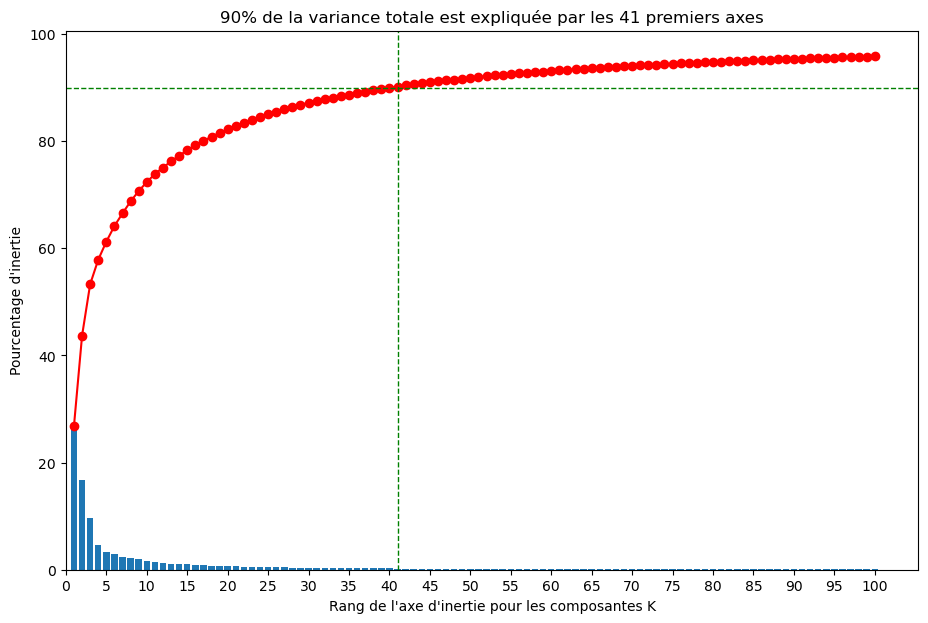

In [149]:
# Affichage du diagramme des éboulis
display_pca_eboulis(pca)

In [150]:
# Transformation inverse (de Vectors à Arrays)
vector_to_array_udf = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))

In [151]:
final_df = pca_matrix.withColumn('features', vector_to_array_udf('features_pca'))

In [152]:
final_df.show(10, True)

+--------------------+--------------+--------------------+--------------------+--------------------+
|                path|         label|         cnn_vectors|        features_pca|            features|
+--------------------+--------------+--------------------+--------------------+--------------------+
|file:/C:/Users/Ha...|Apple Golden 1|[0.0,0.0479974746...|[4.98089584321073...|[4.980896, 5.4048...|
|file:/C:/Users/Ha...|Apple Golden 1|[0.00111107924021...|[5.50980016257361...|[5.5098, 4.626695...|
|file:/C:/Users/Ha...|Apple Golden 1|[0.03722351416945...|[6.39840192490234...|[6.3984017, 4.591...|
|file:/C:/Users/Ha...|Apple Golden 1|[0.0,0.0,0.684601...|[5.43004893616666...|[5.430049, 4.8585...|
|file:/C:/Users/Ha...|Apple Golden 1|[0.0,0.0,0.366576...|[3.98251790524833...|[3.982518, 3.7568...|
|file:/C:/Users/Ha...|Apple Golden 1|[0.0,0.0274292603...|[7.58072670909864...|[7.5807266, 2.013...|
|file:/C:/Users/Ha...|Apple Golden 1|[0.0,0.0785900354...|[4.70645256629018...|[4.7064524, 

#### Enregistrement des données traitées au format "**parquet**" 

In [155]:
print(PATH_Result)

C:\Users\Haci.KIZIL\Desktop\P8_Kapanoglu/data/Results


In [157]:
# Enregistrement des données (format parquet)
final_df.write.mode('overwrite').parquet(PATH_Result)

### Chargement des données enregistrées et validation du résultat

<u>On charge les données fraichement enregistrées dans un **DataFrame Pandas**</u> :

In [158]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

In [159]:
df.head()

,path,label,cnn_vectors,features_pca,features
0,file:/C:/Users/Haci.KIZIL/Desktop/P8_Kapanoglu...,Apple Golden 1,"{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[4.980896, 5.4048862, -5.893636, 9.928784, 0.4..."
1,file:/C:/Users/Haci.KIZIL/Desktop/P8_Kapanoglu...,Apple Golden 1,"{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[5.5098, 4.6266956, -7.2106485, 10.850506, 0.6..."
2,file:/C:/Users/Haci.KIZIL/Desktop/P8_Kapanoglu...,Apple Golden 1,"{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[6.3984017, 4.591377, -6.5240912, 10.619996, -..."
3,file:/C:/Users/Haci.KIZIL/Desktop/P8_Kapanoglu...,Apple Golden 1,"{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[5.430049, 4.8585906, 2.2041416, 10.617527, 5...."
4,file:/C:/Users/Haci.KIZIL/Desktop/P8_Kapanoglu...,Apple Golden 1,"{'type': 1, 'size': None, 'indices': None, 'va...","{'type': 1, 'size': None, 'indices': None, 'va...","[3.982518, 3.756886, 6.0731015, 5.695782, 5.44..."


In [160]:
df.loc[0,'features'].shape

(100,)

In [161]:
df.shape

(1608, 5)

### Arrêt de la session Spark

In [162]:
# Arrêt de la session Spark
spark.stop()